In [1]:
import geopandas as gpd
from shapely.geometry import LineString, Point, MultiLineString
from shapely.ops import substring, nearest_points
import rasterio
from rasterio.plot import show
import matplotlib.pyplot as plt
from collections import defaultdict
import pandas as pd

plt.rcParams['font.sans-serif'] = ['STSong']
plt.rcParams['axes.unicode_minus'] = False

# 加载矢量数据
river_gdf = gpd.read_file('../data/最新赣江河流.shp')
intersection_gdf = gpd.read_file('../data/河流交汇点.shp')
# duanmian_gdf = gpd.read_file('../data/含有保留点的总候选点.shp')
# duanmian_gdf = gpd.read_file('../data/优化后的常规监测站点.shp')
# duanmian_gdf = gpd.read_file('../result/全部重插入/调整现有监测点布局最佳监测点_51_points.shp')
duanmian_gdf = gpd.read_file('../data/交界-入河口断面.shp')


# 打印矢量数据的坐标系
print("河流坐标系 CRS:", river_gdf.crs)
print("河流交汇点坐标系 CRS:", intersection_gdf.crs)
print("断面点坐标系 CRS:", duanmian_gdf.crs)


河流坐标系 CRS: EPSG:4326
河流交汇点坐标系 CRS: EPSG:4326
断面点坐标系 CRS: EPSG:4326


In [2]:
# print(river_gdf.shape)  # 查看 river_gdf 中的河流条数
# print(river_gdf.head())  # 查看 river_gdf 中的一些记录
# 检查河流数据中的几何类型
geometry_types = river_gdf.geometry.apply(lambda geom: geom.geom_type)
print(geometry_types.value_counts())

# 筛选出几何类型为 MultiLineString 的河流
multilinestring_rivers = river_gdf[river_gdf.geometry.apply(lambda geom: geom.geom_type == 'MultiLineString')]

# 查看 MultiLineString 河流的数量和相关信息
print(f"共找到 {len(multilinestring_rivers)} 条河流为 MultiLineString 类型")
print(multilinestring_rivers[['编码', '名称', 'geometry']])  # 根据需要选择要查看的字段




LineString    27
Name: count, dtype: int64
共找到 0 条河流为 MultiLineString 类型
Empty GeoDataFrame
Columns: [编码, 名称, geometry]
Index: []


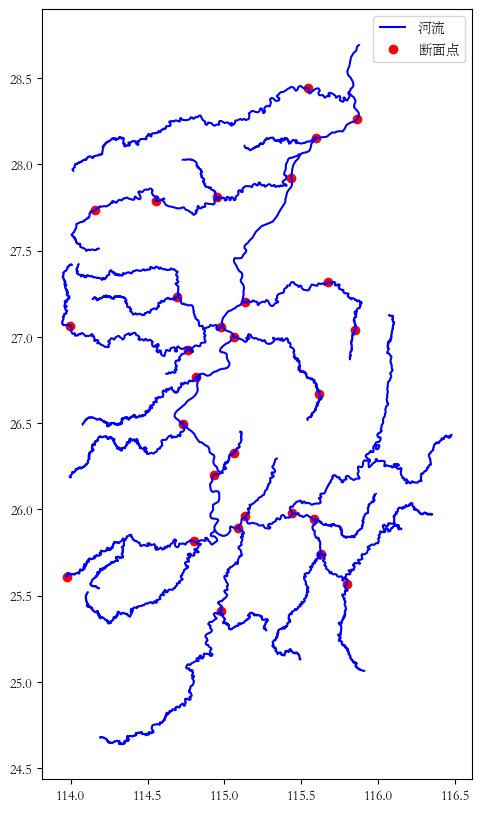

In [3]:
# 可视化检查断面点和河流数据
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(10, 10))
river_gdf.plot(ax=ax, color='blue', label='河流')
duanmian_gdf.plot(ax=ax, color='red', marker='o', label='断面点')
plt.legend()
plt.show()


In [4]:
# 创建断面点缓冲区
def create_upstream_segments(start_point, buffer_length, visited_confluences, total_upstream_segments):
    if buffer_length <= 0:
        print(f"缓冲区长度已耗尽，结束递归")
        return total_upstream_segments

    current_point = start_point.geometry.iloc[0]
    print(f"当前处理的断面点坐标：{current_point}")
    
    point_buffer = current_point.buffer(20)
    print(f"创建缓冲区，半径为20米，缓冲区为：{point_buffer}")
    
    point_gdf = gpd.GeoDataFrame(geometry=[point_buffer], crs=river_gdf.crs)
    containing_rivers = gpd.sjoin(river_gdf, point_gdf, how="inner", predicate='intersects')
    
    if containing_rivers.empty:
        print("警告：起点不在任何河流线上，跳过该点处理。")
    else:
        print(f"找到 {len(containing_rivers)} 条河流与缓冲区相交，开始处理每条河流。")
        for idx, row in containing_rivers.iterrows():
            river_code = row['编码']
            river_name = row['名称']
            river_line = row.geometry
            print(f"处理河流：编码为 {river_code}，名称为 {river_name}")
            
            nearest_point = nearest_points(current_point, river_line)[1]
            print(f"计算最近投影点，最近点为 {nearest_point}")
            
            start_point = nearest_point
            start_distance = river_line.project(start_point)
            print(f"投影点到河流起点的距离为：{start_distance}")
            
            end_distance = max(start_distance - buffer_length, 0)
            print(f"缓冲区长度为 {buffer_length}，上游段终点距离为：{end_distance}")
            
            upstream_segment = substring(river_line, end_distance, start_distance)
            if upstream_segment.is_empty:
                print(f"警告：投影到河流编码为 {river_code} 的河流线上的上游段为空，结束此河流处理。")
                return total_upstream_segments
            else:
                print(f"截取的上游河段为：{upstream_segment}")
                segment_gdf = gpd.GeoDataFrame(geometry=[upstream_segment], crs=river_gdf.crs)
                intersecting_confluences = gpd.sjoin(intersection_gdf, segment_gdf, how="inner", predicate='intersects')
                
                if not intersecting_confluences.empty:
                    num_confluences = len(intersecting_confluences)
                    print(f"在上游河段中找到 {num_confluences} 个交汇点，开始处理交汇点。")
                    
                    for idx, row in intersecting_confluences.iterrows():
                        initial_buffer_length = buffer_length
                        if row.geometry.wkt not in visited_confluences:
                            print(f"该交汇点未被访问过，开始处理。")
                            print(f"交汇点索引：{idx}，交汇码：{row['交汇码']}")
                            
                            visited_confluences.add(row.geometry.wkt)
                            confluence_point = row.geometry
                            confluence_distance = river_line.project(confluence_point)
                            print(f"交汇点距离河流起点的距离为：{confluence_distance}")
                            
                            segment_length = start_distance - confluence_distance
                            print(f"计算截取的上游河段长度：{segment_length}")
                            
                            buffer_length -= segment_length
                            print(f"更新后的缓冲区长度为：{buffer_length}")
                            
                            upstream_segment = substring(river_line, start_distance, confluence_distance)
                            total_upstream_segments.append(upstream_segment)
                            print(f"上游段已添加到结果列表。")
                            
                            confluence_code = row['交汇码']
                            confluence_codes = confluence_code.split(',')
                            print(f"交汇点的交汇码为：{confluence_codes}")
                            
                            create_upstream_segments(
                                gpd.GeoDataFrame(geometry=[confluence_point], crs=river_gdf.crs),
                                buffer_length,
                                visited_confluences,
                                total_upstream_segments
                            )
                        else:
                            print(f"交汇点已被访问过，跳过处理。")
                            print(f"end_distance: {end_distance}")
                            if end_distance != 0:
                                total_upstream_segments.append(upstream_segment)
                            break
                        buffer_length = initial_buffer_length
                else:
                    print(f"此上游段不包含交汇点，直接添加到结果。")
                    total_upstream_segments.append(upstream_segment)
    return total_upstream_segments

# 将所有矢量数据转换为适合测量的投影坐标系（例如，UTM Zone 50N）
river_gdf = river_gdf.to_crs(epsg=32650)
intersection_gdf = intersection_gdf.to_crs(epsg=32650)
duanmian_gdf = duanmian_gdf.to_crs(epsg=32650)

# 输出坐标系
print("河流坐标系 CRS:", river_gdf.crs)
print("河流交汇点坐标系 CRS:", intersection_gdf.crs)
print("河流断面点坐标系 CRS:", duanmian_gdf.crs)

all_upstream_segments = []

# 遍历所有断面点
for idx, selected_feature in duanmian_gdf.iterrows():
    print(f"开始处理断面点：{selected_feature['point_id']}")
    start_point = selected_feature
    buffer_length = 10000 # 设置缓冲区长度为10000米
    visited_confluences = set()
    total_upstream_segments = []
    start_point = gpd.GeoDataFrame(geometry=[start_point.geometry], crs=river_gdf.crs)
    upstream_segments = create_upstream_segments(start_point, buffer_length, visited_confluences, total_upstream_segments)
    
    if upstream_segments:
        # 过滤掉非线段的几何对象
        upstream_segments = [seg for seg in upstream_segments if isinstance(seg, (LineString, MultiLineString))]
        if upstream_segments:
            merged_upstream_segments = gpd.GeoSeries(upstream_segments).unary_union
            print(f"已合并断面点 {selected_feature['point_id']} 的所有上游段。")
            result_gdf = gpd.GeoDataFrame(geometry=[merged_upstream_segments], crs=river_gdf.crs)
            result_gdf['所属点'] = selected_feature['point_id']  # 添加所属点字段
            all_upstream_segments.append(result_gdf)
    else:
        print(f"未找到断面点 {selected_feature['point_id']} 的任何上游段。")

# 将所有断面点的上游段结果合并到一个GeoDataFrame中，并保存为一个Shapefile
if all_upstream_segments:
    combined_gdf = gpd.GeoDataFrame(pd.concat(all_upstream_segments, ignore_index=True))
    # 再次过滤确保所有几何对象都是线段
    combined_gdf = combined_gdf[combined_gdf.geometry.apply(lambda geom: isinstance(geom, (LineString, MultiLineString)))]
    # 将 combined_gdf 的坐标系转换为 EPSG:4326
    combined_gdf_4326 = combined_gdf.to_crs(epsg=4326)

    # 保存为 Shapefile，编码设置为 'utf-8'
    combined_gdf_4326.to_file('../data/交界-入河口断面的上游段.shp', encoding='utf-8')

    print("已成功保存 Shapefile，坐标系为 EPSG:4326。")

else:
    print("未找到任何上游段。")


河流坐标系 CRS: EPSG:32650
河流交汇点坐标系 CRS: EPSG:32650
河流断面点坐标系 CRS: EPSG:32650
开始处理断面点：2
当前处理的断面点坐标：POINT (346054.79830890114 3089138.9656683244)
创建缓冲区，半径为20米，缓冲区为：POLYGON ((346074.79830890114 3089138.9656683244, 346074.7020034346 3089137.0053255176, 346074.4140145092 3089135.063861884, 346073.93711561576 3089133.1599747795, 346073.27589955134 3089131.311999677, 346072.4367341881 3089129.537733588, 346071.4277011472 3089127.8542636638, 346070.2585179684 3089126.277802641, 346068.94044452487 3089124.8235327005, 346067.4861745844 3089123.505459257, 346065.90971356153 3089122.336276078, 346064.2262436377 3089121.3272430375, 346062.4519775484 3089120.488077674, 346060.6040024462 3089119.8268616097, 346058.70011534146 3089119.3499627165, 346056.7586517077 3089119.061973791, 346054.79830890114 3089118.9656683244, 346052.83796609455 3089119.061973791, 346050.8965024608 3089119.3499627165, 346048.99261535605 3089119.8268616097, 346047.14464025386 3089120.488077674, 346045.3703741646 3089121.327243037